In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import re
import math
import pickle
from collections import Counter
import seaborn as sns
from sklearn.model_selection import learning_curve

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


In [2]:
class PhishingModel():
    def __init__(self,file_name):
        self.url_data = pd.read_csv(file_name,error_bad_lines=False).sample(frac=1).reset_index(drop=True)
        self.bad_data = self.url_data[self.url_data['label']=='bad']
        self.good_data = self.url_data[self.url_data['label']=='good']
        self.preprocess_data = []
        self.labels=[]
        self.tfidf = TfidfVectorizer(tokenizer=self.pre_process_url)
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.count=None
        self.model = GaussianNB()
        self.sm = SMOTE(random_state=2)
        
    def printData(self):
        print(self.url_data[:20])
        
    def create_graph(self,labels,counts,title):
        plt.title(title)
        plt.bar(labels,counts)
        plt.xlabel("Labels")
        plt.ylabel("Counts")
        plt.plot()
        
    def model_bar_graph(self,urls):
        labels = np.unique(self.url_data['label'].values)
        counts = []
        for x in labels:
            counts.append(len(self.url_data[self.url_data['label']==x].values))
        total = sum(counts)
        for i in range(len(counts)):
            counts[i] = round(((counts[i]/total)*100),2)
        self.create_graph(labels,counts,"URL count")
    
    
        
    def draw_bar_graph(self,url,title):
        labels = []
        total=0
        counts=[]
        for x in url:
            total+=url[x]
            counts.append(url[x])
            if(x==1):
                labels.append("good")
            else:
                labels.append("bad")
            
        for i in range(len(counts)):
            counts[i] = round(((counts[i]/total)*100),2)
        self.create_graph(labels,counts,title)
        
    def check_balance(self):
        #calculate Shannon entropy
        #refer to url: https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance
        entropy = 0.0
        labels = np.unique(self.url_data['label'].values)
        counts = []
        for x in labels:
            counts.append(len(self.url_data[self.url_data['label']==x].values))
        entropy = 0.0
        total = sum(counts)
        for x in counts:
            entropy += (-(x/total)*np.log(x/total))
        shannon_en = entropy/np.log(len(counts))
        shannon_en = round(shannon_en,3)
        if(shannon_en > 0.8):
            print("Data is Balanced")
            print("Calculated Entrophy: ",shannon_en)
        else:
            print("Data is Imbalanced")
            print("Calculated Entrophy: ",shannon_en)
            
    def pre_process_url(self,url):
        data = str(url.encode('utf-8')).split('/')
        total_token = []
        for x in data:
            token = str(x).split('-')
            token_by_dot=[]
            for y in token:
                temp_token = str(y).split('.')
                token_by_dot+=temp_token
            total_token =total_token+token+ token_by_dot
        total_token = list(set(total_token))
        
        if 'com' in total_token:
            total_token.remove('com')
        for i in range(len(total_token)):
            total_token[i] = re.sub(r"[b']+",'',total_token[i])
        if '' in total_token:
            total_token.remove('')
        return total_token
    
    def save_tfidf(self):
        pickle.dump(self.tfidf, open("tfidf.pickle", "wb"))
        
    def process_data(self,sample=20,train_all=0):
        c=0
        url = self.url_data['url']
        label = self.url_data['label']
        
        if(train_all==1):
            #for safe side, i am taking 5% of the total data
            #RAM requirment may increase more than 25 GB(tested on Google Colab)
            sample = int(0.05*len(self.url_data))
        
        check_data=[]
        for i in range(sample):
            check_data.append(url[i])
        self.preprocess_data = self.tfidf.fit_transform(check_data)
        for y in label:
            if(y=='good'):
                self.labels.append(1)
            else:
                self.labels.append(0)
            c+=1
            if(c==sample):
                break
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.preprocess_data,self.labels,test_size=0.2,random_state=42)
    
    #apply smote to handle imblance data
    def handle_imbalance_data(self):
        #before smote
        before_smote = Counter(self.y_train)
#         print("Before SMOTE")
#         print(before_smote)
        
        self.x_train,self.y_train = self.sm.fit_sample(self.x_train,self.y_train)
        after_smote = Counter(self.y_train)
#         print("After SMOTE")
#         print(after_smote)
        
        return before_smote,after_smote
        
    def train_model(self):
        self.model.fit(self.x_train.toarray(),self.y_train)
        joblib.dump(self.model,"train_model.pkl")
    
    def test_accuracy(self):
        self.model= joblib.load('train_model.pkl')
        predicted_label = self.model.predict(self.x_test.toarray())
        acc = accuracy_score(self.y_test,predicted_label)*100
        print(str(acc)+'%')
        
    def print_confusion_matrix(self):
        self.model= joblib.load('train_model.pkl')
        predicted_label = self.model.predict(self.x_test.toarray())
        data = confusion_matrix(self.y_test,predicted_label)
        df_cm = pd.DataFrame(data, columns=np.unique(self.y_test), index = np.unique(self.y_test))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (10,7))
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
    
    def print_classification_report(self):
        self.model= joblib.load('train_model.pkl')
        predicted_label = self.model.predict(self.x_test.toarray())
        print(classification_report(self.y_test,predicted_label))
        
    def predict_type(self,url):
        self.model= joblib.load('train_model.pkl')
        self.tfidf = pickle.load(open("tfidf.pickle", "rb"))
        prep = self.tfidf.transform([url])
        flag = self.model.predict(prep.toarray())
        if(flag[0]==1):
            return "Url is Good"
        else:
            return "Url is Bad"
            
    def check_security(self):
        urls = self.bad_data['url'].values
        tech_gaint = {'facebook':0,'twitter':0,'ebay':0,'amazon':0,'linkedin':0,'quora':0,'youtube':0}
        
        for x in tech_gaint:
            wrd = r'\b'+str(x)+'\\b'
            for url in urls:
                clean_url = str(url.encode('utf-8'))
                if(len(re.findall(wrd, clean_url))>0):
                    tech_gaint[x]+=1
        company = []
        counts = []
        for x in tech_gaint:
            company.append(x)
            counts.append(tech_gaint[x])
        mx=0
        pos=0
        for i in range(len(counts)):
            if(mx<counts[i]):
                mx = counts[i]
                pos = i
        print(company[pos] + " have highest number of Phishing Rate with count of "+str(mx))
        print(company[pos] + " have to improve it security")
        self.create_graph(company,counts,"Phishing Url Count")
        

In [84]:
if __name__ == "__main__":
    eda = PhishingModel("data.csv")
    #here, we will put number of random sample and put one flag value, which will test that
    eda.process_data(sample=1000,train_all=0)

In [85]:
#it has two parameter
#sample
#train_all, It will help to decide, train whole dataset or train with it decided number of sample
eda.check_balance()

Data is Imbalanced
Calculated Entrophy:  0.68


In [86]:
bf_smt,af_smt = eda.handle_imbalance_data()

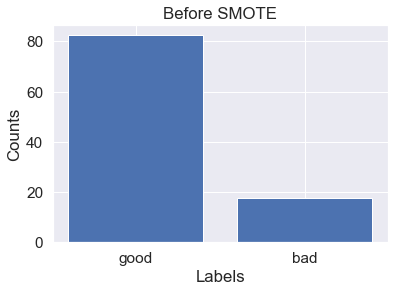

In [87]:
eda.draw_bar_graph(bf_smt,"Before SMOTE")

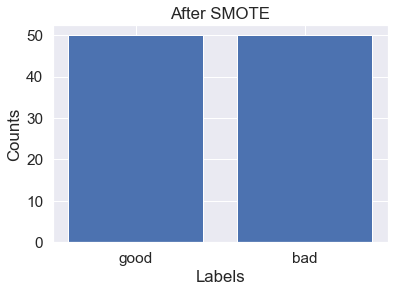

In [88]:
eda.draw_bar_graph(af_smt,"After SMOTE")

In [89]:
eda.train_model()
eda.save_tfidf()

In [94]:
url_list = ["twitter.com","amazon.com","zyz.com","plaq.com","youtube.com","netflix.com"]
for x in url_list:
    print("URL: ",x)
    print("Prediction: ",eda.predict_type(x))

URL:  twitter.com
Prediction:  Url is Good
URL:  amazon.com
Prediction:  Url is Good
URL:  zyz.com
Prediction:  Url is Bad
URL:  plaq.com
Prediction:  Url is Bad
URL:  youtube.com
Prediction:  Url is Good
URL:  netflix.com
Prediction:  Url is Bad
